In [ ]:
# Web Application Attack Detection using Random Forest

## Author: Shalev Mazuz
## Description: This notebook implements a Random Forest classifier to detect web application attacks.

In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Other
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from google.colab import drive


In [3]:
# Load dataset
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Shalev Mazuz- Final report/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX-CSV.csv")

# Quick overview
df.head()
df.info()
df.describe()


Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             170366 non-null  int64  
 1    Flow Duration                170366 non-null  int64  
 2    Total Fwd Packets            170366 non-null  int64  
 3    Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets   170366 non-null  int64  
 5    Total Length of Bwd Packets  170366 non-null  int64  
 6    Fwd Packet Length Max        170366 non-null  int64  
 7    Fwd Packet Length Min        170366 non-null  int64  
 8    Fwd Packet Length Mean       170366 non-null  float64
 9    Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max         170366 non-null  int64  
 11   Bwd Packet Length Min        170366 non-null  int64  
 12   Bwd Packet Length

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,170366.000000,1.703660e+05,170366.000000,170366.000000,1.703660e+05,1.703660e+05,170366.000000,170366.000000,170366.000000,170366.000000,...,170366.000000,170366.000000,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05
mean,7897.090599,1.246354e+07,15.124620,18.022276,5.569859e+02,3.183147e+04,167.775982,22.697786,48.233250,47.235628,...,11.925108,25.584506,7.433804e+04,4.676038e+04,1.646422e+05,5.012699e+04,3.690478e+06,1.310724e+05,3.784764e+06,3.543232e+06
std,18235.489428,3.193852e+07,1123.107756,1494.492871,7.710431e+03,3.460816e+06,461.299214,37.990783,94.947821,141.927429,...,1077.898793,6.354041,6.182048e+05,3.689605e+05,9.958673e+05,5.606797e+05,1.298830e+07,1.733767e+06,1.325135e+07,1.284183e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,1.920000e+02,1.000000,1.000000,3.100000e+01,6.000000e+00,23.000000,0.000000,7.882314,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,3.141200e+04,2.000000,2.000000,6.800000e+01,1.340000e+02,41.000000,6.000000,38.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.169818e+05,4.000000,2.000000,1.480000e+02,3.280000e+02,60.000000,41.000000,50.000000,17.897858,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65529.000000,1.200000e+08,200755.000000,270686.000000,1.197199e+06,6.270000e+08,23360.000000,1729.000000,4183.057143,5463.493850,...,192491.000000,60.000000,1.030000e+08,6.370000e+07,1.030000e+08,1.030000e+08,1.200000e+08,7.260000e+07,1.200000e+08,1.200000e+08


In [ ]:
# Alter to binary labels
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].apply(lambda x: 'BENIGN' if x.strip().upper() == 'BENIGN' else 'ATTACK')

# Remove problemtaic rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Separate features and target
X = df.drop("Label", axis=1)
y = df["Label"]

# Encode categorical features
le = LabelEncoder()
y = le.fit_transform(df['Label'])

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)

# Check for class imbalance
print("Class distribution:", Counter(y))



Class distribution: Counter({np.int64(1): 168051, np.int64(0): 2180})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Model training
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

Accuracy: 0.9998825153464329

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       436
           1       1.00      1.00      1.00     33611

    accuracy                           1.00     34047
   macro avg       1.00      1.00      1.00     34047
weighted avg       1.00      1.00      1.00     34047


Confusion Matrix:


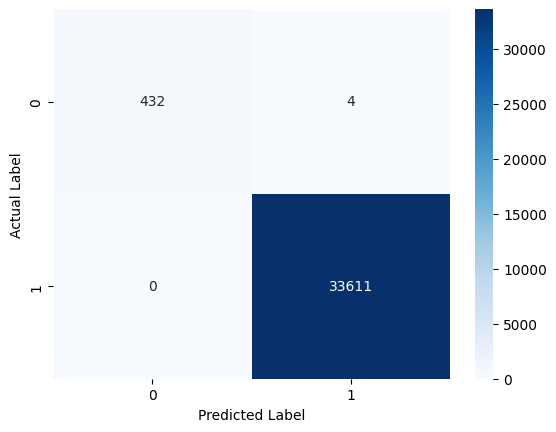

<Axes: title={'center': 'Feature Importance'}>

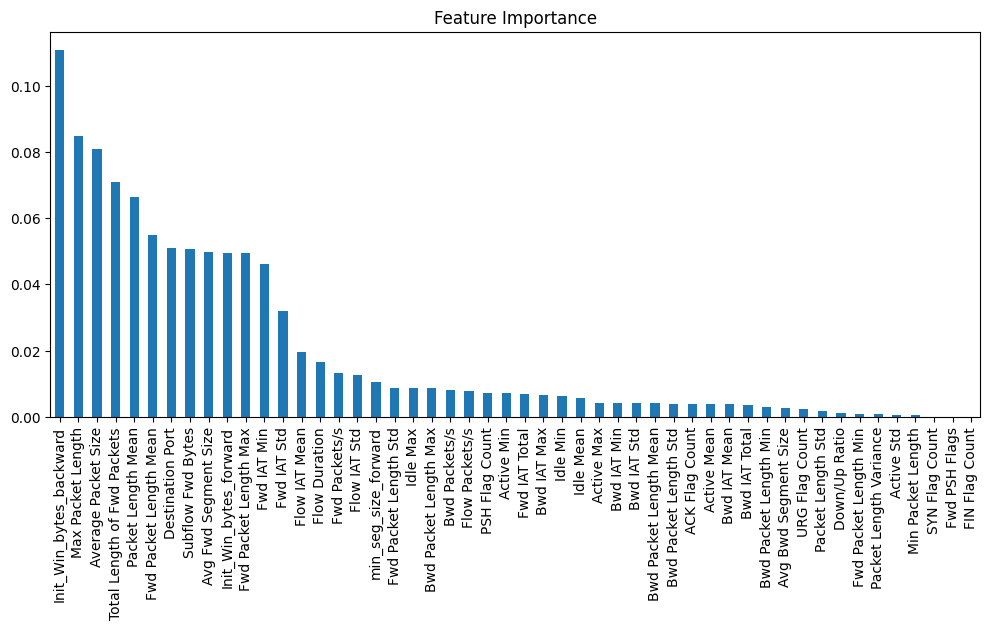

In [ ]:
# Model evaluation
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 5), title="Feature Importance")


In [ ]:
import numpy as np

# get predictions
y_pred = rf.predict(X_test)

# find indices of FP and FN
fn_indices = np.where((y_pred == 1) & (y_test == 0))[0]

print("False Positive examples:", fp_indices)
print("False Negative examples:", fn_indices)

# pick one FP and one FN
fn_idx = fn_indices[0]

print("\nFalse Negative sample:\n", X_test.iloc[fn_idx])
print("True label:", y_test[fn_idx], "Predicted:", y_pred[fn_idx])
print("log 20000: \n", X_test.iloc[20000])
print("log 28616: \n", X_test.iloc[28616])


False Positive examples: []
False Negative examples: [ 2627 17955 20000 28616]

False Negative sample:
 Destination Port              -0.428196
Flow Duration                 -0.390402
Total Length of Fwd Packets   -0.072266
Fwd Packet Length Max         -0.363850
Fwd Packet Length Min         -0.597640
Fwd Packet Length Mean        -0.508179
Fwd Packet Length Std         -0.332946
Bwd Packet Length Max         -0.494467
Bwd Packet Length Min         -0.732137
Bwd Packet Length Mean        -0.583803
Bwd Packet Length Std         -0.447228
Flow Packets/s                -0.218540
Flow IAT Mean                 -0.226408
Flow IAT Std                  -0.272768
Fwd IAT Total                 -0.383264
Fwd IAT Std                   -0.306678
Fwd IAT Min                   -0.130941
Bwd IAT Total                 -0.364409
Bwd IAT Mean                  -0.196192
Bwd IAT Std                   -0.251586
Bwd IAT Max                   -0.275061
Bwd IAT Min                   -0.131807
Fwd PSH Flags   

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Run the same experiment with different number of fetearues selected
def run_experiment(X, y, k_features):
    df = pd.read_csv("/content/drive/MyDrive/Web Application Attack - Shalev Mazuz/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX-CSV.csv")
    # Alter to binary class
    df.columns = df.columns.str.strip()
    df['Label'] = df['Label'].apply(lambda x: 'BENIGN' if x.strip().upper() == 'BENIGN' else 'ATTACK')

    # Remove problemtaic rows
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # Separate features and target
    X = df.drop("Label", axis=1)  # Replace "label" with the actual target column
    y = df["Label"]

    # Encode categorical features
    le = LabelEncoder()
    y = le.fit_transform(df['Label'])

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Feature selecting
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X.columns[selector.get_support()]
    X = pd.DataFrame(X_selected, columns=selected_features)

    # Model training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    # Model evaluation
    y_pred = rf.predict(X_test)

    # Collect metrics
    results = {
        'k_features': k_features,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, pos_label=0),
        'recall': recall_score(y_test, y_pred, pos_label=0),
        'f1_score': f1_score(y_test, y_pred, pos_label=0)
    }
    return results


In [ ]:
results = []
num_features = [5,10,25,40,50,60,77]
for k in num_features:
        result = run_experiment(X, y, k)
        results.append(result)


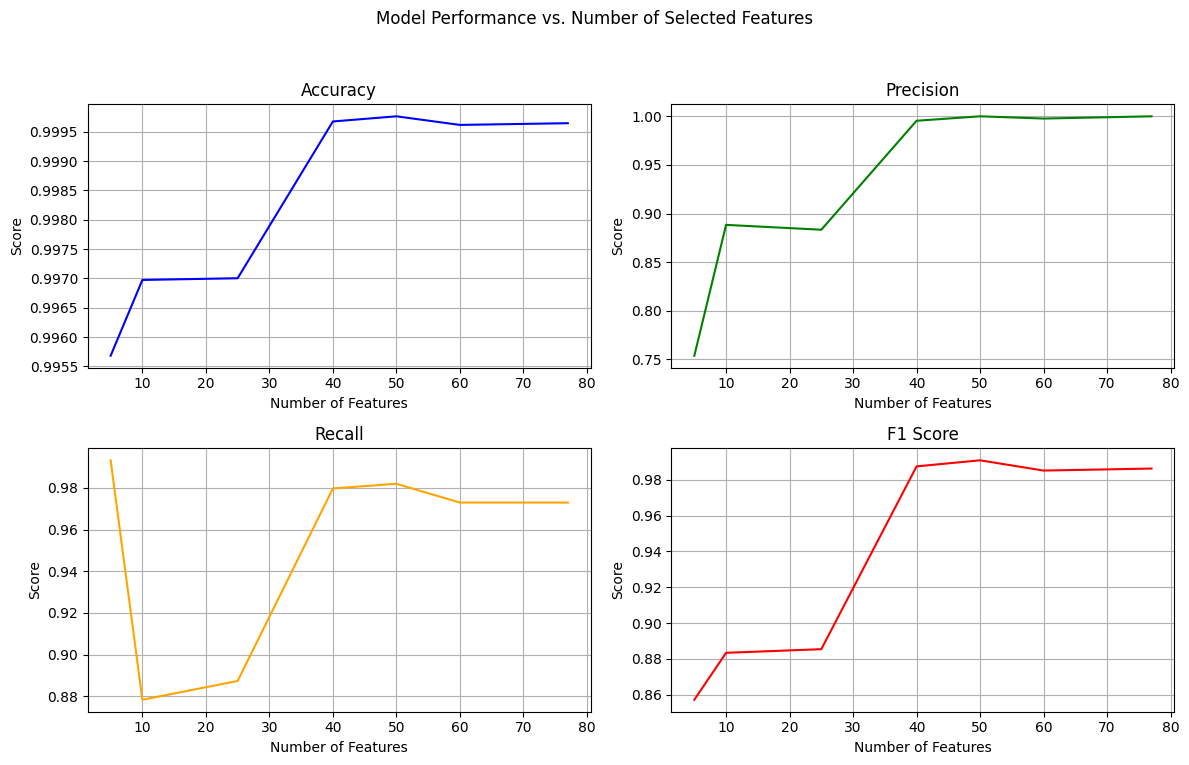

In [ ]:
results_df = pd.DataFrame(results)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance vs. Number of Selected Features')

# Accuracy
axs[0, 0].plot(results_df['k_features'], results_df['accuracy'], color='blue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Number of Features')
axs[0, 0].set_ylabel('Score')
axs[0, 0].grid(True)

# Precision
axs[0, 1].plot(results_df['k_features'], results_df['precision'], color='green')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Number of Features')
axs[0, 1].set_ylabel('Score')
axs[0, 1].grid(True)

# Recall
axs[1, 0].plot(results_df['k_features'], results_df['recall'], color='orange')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Number of Features')
axs[1, 0].set_ylabel('Score')
axs[1, 0].grid(True)

# F1 Score
axs[1, 1].plot(results_df['k_features'], results_df['f1_score'], color='red')
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('Number of Features')
axs[1, 1].set_ylabel('Score')
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

